# Cheat sheet - Option Pricing with Heston Model and Black-Scholes
François Goujon

Content : Heston model implementation for option pricing. Volatility smile plotting. Comparison with Black-Scholes model.

### Table of Contents

* [Monte Carlo Simulation](#mc)
    * [Functions](#mc_func)
    * [Results](#mc_res)
        * [Parameters](#mc_param)
        * [Computations](#mc_comp)
        * [Implied vol](#mc_iv)
    
* [Black-Scholes](#bs)
    * [Functions](#bs_func)
    * [Results](#bs_res)
        * [Pricing](#bs_pr)
        * [Implied vol](#bs_iv)

### Heston model price and variance evolution: <br>
#### Price:
$$
\frac{dS_t}{S_t} = rdt + \sqrt{v_t}dW_t^s \quad and \ dW_t^s \sim N(0,dt) \ with \ \langle dW^s, dW^v \rangle_t = \rho dt \\
i.e \ dW_t^s = Z^s\sqrt{dt} \ with \ Z^s \sim N(0,1) \ and \ \langle Z^s, Z^v \rangle = \rho \\
\quad \\
\frac{dS_t}{S_t} = rdt + \sqrt{v_t}Z^{s}\sqrt{dt} \ ; \ with \ Y_t = \ln(S_t) \Rightarrow dY_t = (r - \frac{v_t}{2})dt + \sqrt{v_t}Z^{s}\sqrt{dt} \quad (dY = \frac{dS}{S} - \frac{1}{2S^2} \langle dS, dS \rangle )\\
$$
#### Variance:
$$
dv = \kappa(\theta - v_t)dt + \sigma\sqrt{v_t}dW_t^v \ and \ dW_t^v \sim N(0,dt) \ with \ \langle dW^s, dW^v \rangle_t = \rho dt \\
i.e \ dW_t^v = Z^v\sqrt{dt} \ with \ Z^v \sim N(0,1) \ and \ \langle Z^s, Z^v \rangle = \rho \\
\quad \\
dv = \kappa(\theta - v_t)dt + \sigma\sqrt{v_t}Z^{v}\sqrt{dt}\\
$$
#### Discretize:
$$
Y_i = Y_{i-1} + (r - \frac{V_{i-1}}{2})dt + \sqrt{V_{i-1}}Z_{i-1}^{s}\sqrt{dt} \\
\Rightarrow S_i = S_{i-1}.\exp((r - \frac{V_{i-1}}{2})dt + \sqrt{V_{i-1}}Z_{i-1}^{s}\sqrt{dt}) \\
\quad \\
V_i = V_{i-1} + \kappa(\theta - V_{i-1})dt + \sigma\sqrt{V_{i-1}}Z_{i-1}^{v}\sqrt{dt} \quad \ if > 0 \ \ else \ 0 \\
$$

In [1]:
# Imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol_vollib

## Monte Carlo simulation <a class="anchor" id="mc"></a>

## Functions <a class="anchor" id="mc_func"></a>

In [2]:
def heston_model(s0, v0, r, rho, kappa, theta, sigma, t, n, m):
    """
    Computes Heston model simulations for the chosen parameters
    
    Inputs:
    - s0, v0: initial parameters for asset and variance
    - r: risk free rate
    - rho: correlation between asset returns and variance
    - kappa: rate of mean reversion in variance process
    - theta: long-term mean of variance process
    - sigma: vol of vol / volatility of variance process
    - t: time of simulation in years
    - n: number of time steps
    - m: number of simulations
    
    Outputs:
    - Asset prices over time (numpy array)
    - Variance over time (numpy array)
    """
    # Initialisation
    dt = t/n
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])
    s = np.full(shape=(n+1, m), fill_value=s0)
    v = np.full(shape=(n+1, m), fill_value=v0)
    # Sampling correlated brownian motions under risk-neutral measure
    z = np.random.multivariate_normal(mu, cov, (n,m))
    
    for i in range(1, n+1):
        s[i] = s[i-1] * np.exp((r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt)*z[i-1,:,0])
        v[i] = np.maximum(v[i-1] + kappa*(theta - v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*z[i-1,:,1], 0)
        
    return s, v

def premium_heston(s0, k, v0, r, rho, kappa, theta, sigma, t):
    """Retruns put and call premium"""

    n = int(t*252)
    m = 100000
    s, v = heston_model(s0, v0, r, rho, kappa, theta, sigma, t, n, m)
    put = np.exp(-r*t)*np.mean(np.maximum(k-s[-1], 0))
    call = np.exp(-r*t)*np.mean(np.maximum(s[-1]-k, 0))
    return [put, call]
    
def plot_price_var(s, v, t, n):
    """
    Plot of price and variance evolution of the asset following Heston simulation
    
    Inputs:
    - s, v: Time array of asset price/variance evolution
    - t: Time to maturity 
    - n: Number of time steps
    """
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(26, 6))
    time = np.linspace(0, t, n+1)
    ax1.plot(time, s)
    ax1.set_title("Simulations of asset price evolution")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Asset Price")
    
    ax2.plot(time, v)
    ax2.set_title("Simulations of asset variance evolution")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Asset Variance")
    
    plt.show()
    
def plot_value_distrib(s0, r, ss, rhos, theta, t, m):
    """
    Plot of value distribution at maturity
    
    Inputs:
    - s0: initial price of asset
    - r: risk free rate
    - ss: List of results of simulations of asset price evolution 
    - rhos: List of correlations between asset returns and variance used for simulations
    - theta: long-term mean of variance process
    - t: Time to maturity
    - m: number of simulations
    """
    geo_brownian_motion = s0*np.exp((r - 0.5*theta)*t + np.sqrt(theta)*np.random.normal(0,t,m))
    
    fig, ax = plt.subplots(figsize=(10,5))
    for s, rho in zip(ss, rhos):
        ax = sns.kdeplot(s[-1], label=fr"$\rho= {rho}$", ax=ax)
    ax = sns.kdeplot(geo_brownian_motion, label="GBM", ax=ax)
    ax.set_title("Asset Price Density under Heston Model")
    ax.set_xlim([0.2*s0,2*s0])
    ax.set_xlabel("S")
    ax.set_ylabel("Density")
    plt.legend()
    plt.show()

def plot_option_price_ame(s0, ss, r, t):
    """
    NOT USED
    Plot american options premiums depending on strike. 
    The mean of s-k (resp k-s) is taken for all dates between day 1 and day T.
    Not sure this makes much sens

    Inputs:
    - s0: initial asset price
    - ss: List of results of simulations of asset price evolution 
    - r: risk free rate
    - T: time to maturity
    Outputs:
    - ks: List of strikes
    - puts_list, calls_list: List of values of options at maturity i.e their price
    """
    # Set strikes and complete MC option price for different strikes
    ks = np.arange(0.2*s0, 2*s0, 0.01*s0)

    puts_list = []
    calls_list = []
    
    for s in ss:
        puts = np.array([np.exp(-r*t)*np.mean(np.maximum(k-s, 0)) for k in ks])
        calls = np.array([np.exp(-r*t)*np.mean(np.maximum(s-k, 0)) for k in ks])
        puts_list.append(puts)
        calls_list.append(calls)
    print("Value expectetion done.")

    ns = len(ss)
    rows = int(np.ceil(ns/3))

    fig, axs= plt.subplots(rows,3, figsize=(26, 6*rows))
    for i, ax in enumerate(axs.flatten()[:ns]):
        ax.plot(ks, calls_list[i], label="Call premiums")
        ax.plot(ks, puts_list[i], label="Put premiums")
        ax.set_ylabel("Premium")
        ax.set_xlabel("Strike")
        ax.set_title(f"Option premium {i+1} under Heston Model")
        ax.legend()
    plt.show()

    return ks, calls_list, puts_list

def plot_option_price_eur(s0, ss, r, t):
    """
    Plot european options premiums depending on strike.
    The mean of s-k (resp k-s) is taken for the last date.

    Inputs:
    - s0: initial asset price
    - ss: List of results of simulations of asset price evolution 
    - r: risk free rate
    - T: time to maturity
    Outputs:
    - ks: List of strikes
    - puts_list, calls_list: List of values of options at maturity i.e their price
    """
    # Set strikes and complete MC option price for different strikes
    ks = np.arange(0.2*s0, 2*s0, 0.01*s0)

    puts_list = []
    calls_list = []
    
    for s in ss:
        puts = np.array([np.exp(-r*t)*np.mean(np.maximum(k-s[-1], 0)) for k in ks])
        calls = np.array([np.exp(-r*t)*np.mean(np.maximum(s[-1]-k, 0)) for k in ks])
        puts_list.append(puts)
        calls_list.append(calls)
    print("Value expectetion done.")

    ns = len(ss)
    rows = int(np.ceil(ns/3))

    fig, axs= plt.subplots(rows,3, figsize=(26, 6*rows))
    for i, ax in enumerate(axs.flatten()[:ns]):
        ax.plot(ks, calls_list[i], label="Call premiums")
        ax.plot(ks, puts_list[i], label="Put premiums")
        ax.set_ylabel("Premium")
        ax.set_xlabel("Strike")
        ax.set_title(f"Option premium {i+1} under Heston Model")
        ax.legend()
    plt.show()

    return ks, calls_list, puts_list

def plot_vol_smile(s0, ks, calls_list, puts_list, r, t, implementation="vollib"):
    """
    Plot volatility (=std) depending on strike
    
    Inputs:
    - s0: initial asset price
    - ss: List of results of simulations of asset price evolution 
    - r: risk free rate
    - t: time to maturity
    - implementation: implied_vol algorithm : "vollib" or "own"
    """
    puts_impvol_list = []
    calls_impvol_list = []
    
    for ca, pu in zip(calls_list, puts_list):
        if implementation == "vollib":
            put_impvol = implied_vol_vollib(pu, s0, ks, t, r, flag="p", q=0, return_as='numpy', on_error='ignore')
            call_impvol = implied_vol_vollib(ca, s0, ks, t, r, flag="c", q=0, return_as='numpy', on_error='ignore')
        elif implementation == "own":
            put_impvol = implied_vol(s0, ks, t, r, pu, opt_type = "put", clean=True) 
            call_impvol = implied_vol(s0, ks, t, r, ca, opt_type = "call", clean=True)
        else:
            raise("Implementation doesn't exist")
        puts_impvol_list.append(put_impvol)
        calls_impvol_list.append(call_impvol)
    print("Implied volatility (std) calculation done.")
    
    ns = len(calls_list)
    rows = int(np.ceil(ns/3))

    fig, axs= plt.subplots(rows,3, figsize=(26, 6*rows))
    for i, ax in enumerate(axs.flatten()[:ns]):
        ax.plot(ks, calls_impvol_list[i], label="Implied Vol Calls")
        ax.plot(ks, puts_impvol_list[i], label="Implied Vol Puts")
        ax.set_ylabel("Implied volatility (std)")
        ax.set_xlabel("Strike")
        ax.set_title(f"Implied volatility (std) {i+1} under Heston Model")
        ax.legend()
    plt.show()
    return puts_impvol_list, calls_impvol_list

## Results <a class="anchor" id="mc_res"></a>

### Parameters <a class="anchor" id="mc_param"></a>

In [3]:
# Heston paramaters

s0 = 100.0  # Asset price
v0 = 0.25**2   # initial variance under risk-neutral dynamics
r = 0.01   # Risk free rate
rho = 0.7      # correlation between returns and variances under risk-neutral dynamics
kappa = 3  # Rate of mean reversion of variance under risk-neutral dynamics
theta = 0.2**2 # long-term mean of variance under risk-neutral dynamics
sigma = 0.6    # volatility of volatility

# Simualtion parameters

T = 1.0    # Time to maturity in years
N = 252    # Number of time steps in simulation (Trading days in 1 year)
M = 100000   # Number of simulations

In [4]:
print(v0) # Initial variance
print(theta) # Long term mean of variance

0.0625
0.04000000000000001


In [5]:
premium_heston(s0, 110, v0, r, rho, kappa, theta, sigma, T)

[14.549674648291973, 5.585439694614138]

### Computations <a class="anchor" id="mc_comp"></a>

In [12]:
# Heston model 
s1, v1 = heston_model(s0, v0, r, rho, kappa, theta, sigma, T, N, M)
s2, v2 = heston_model(s0, v0, r, -rho, kappa, theta, sigma, T, N, M)
s3, v3 = heston_model(s0, v0, r, 0, kappa, theta, sigma, T, N, M)

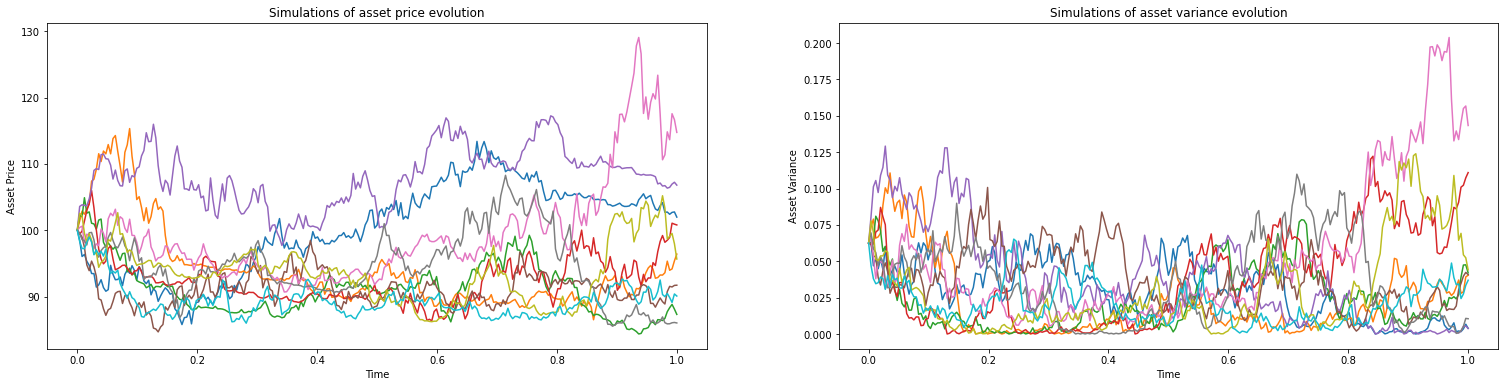

In [13]:
# Plot Heston model asset price evolution
plot_price_var(s1[:, :10], v1[:, :10], T, N)

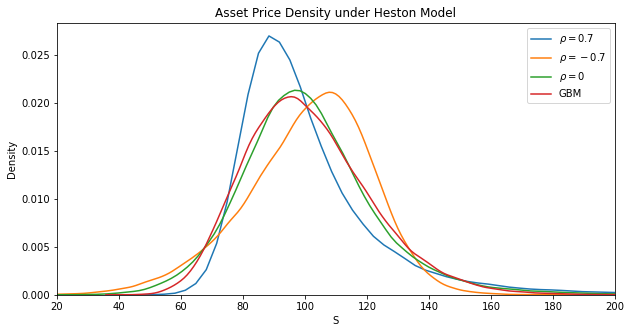

In [14]:
# Plot Heston model asset price distribution at maturity
plot_value_distrib(s0, r, [s1, s2, s3], [rho, -rho, 0], theta, T, M)

Value expectetion done.


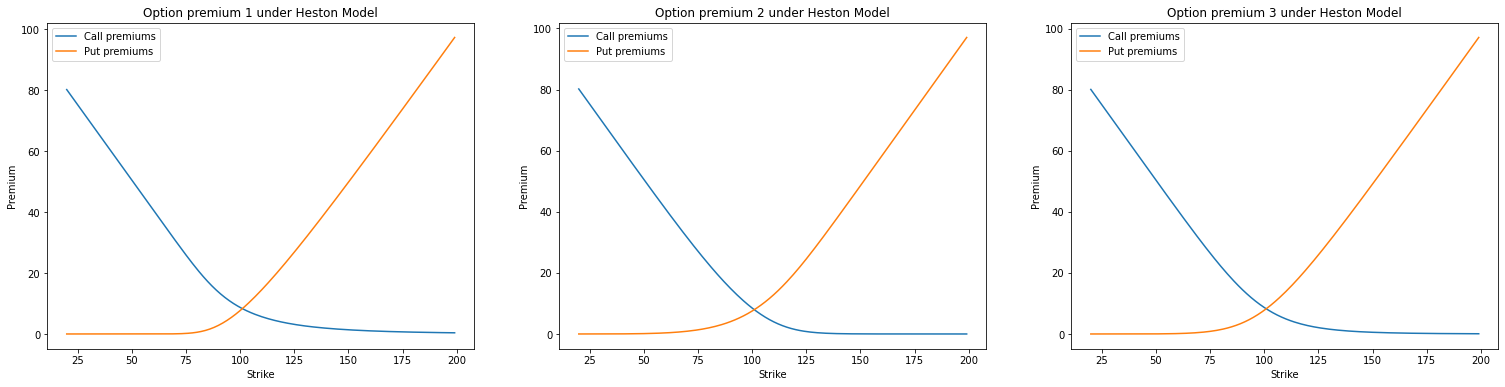

In [15]:
# Plot Heston model european option premiums depending on strike with MC
ks_eur, calls_list_eur, puts_list_eur = plot_option_price_eur(s0, [s1, s2, s3], r, T)

### Implied volatility <a class="anchor" id="mc_iv"></a>

Implied volatility (std) calculation done.


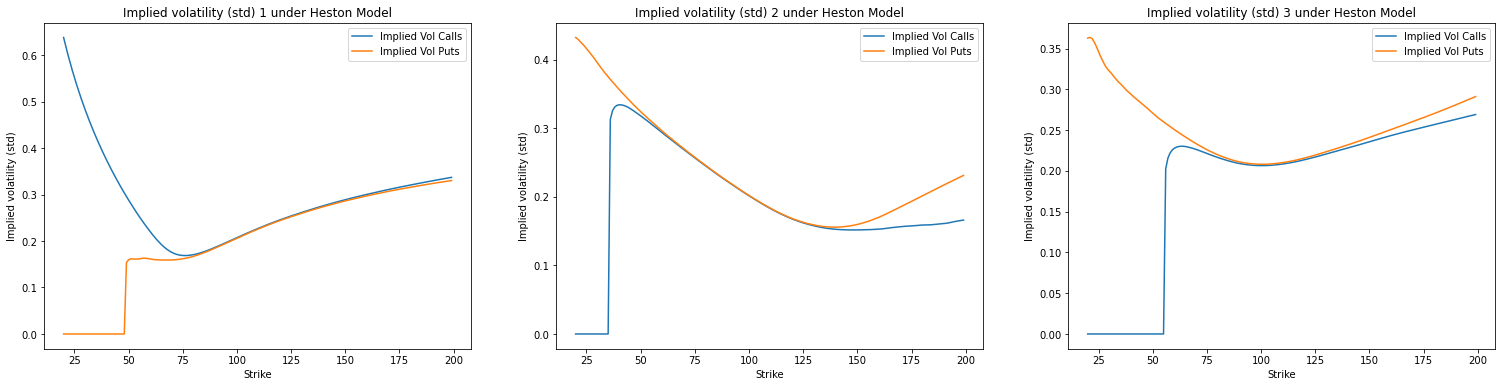

In [16]:
# Implied volatility for european options
piv, civ = plot_vol_smile(s0, ks_eur, calls_list_eur, puts_list_eur, r, T)

In [17]:
print(calls_list_eur[0][30], civ[0][30])

50.545905097789735 0.2881417672500819


For the first chart, European option with strike 50 (idx 30 because we start at 20 with step 1) is worth 50.546 and implied vol is 0.288

# Black-Scholes <a class="anchor" id="bs"></a>
We code was taken from the BlackScoles.ipynb notebook

### Price evolution under risk-neutral measure (Black-Scholes):
$$
\frac{dS_t}{S_t} = rdt + \sigma dW_t = rdt + \sqrt{v} dW_t \\
With \ Y_t = \ln(S_t) \ and \ Ito \rightarrow dY_t = \frac{\partial ln}{\partial x}(S_t)dS_t + \frac{1}{2}\frac{\partial^{2} ln}{\partial x^2}(S_t)d \langle S, S \rangle_t = \frac{dS_t}{S_t} - \frac{1}{2S_t^2}d \langle S, S \rangle_t = \frac{dS_t}{S_t} - \frac{v}{2}dt\\
\quad \\
dY_t = (r - \frac{v}{2})dt + \sqrt{v}dW_t \Rightarrow Y_t = Y_0 + (r - \frac{v}{2})t + \sqrt{v}W_t \\
S_t = e^{Y_t} \Rightarrow S_t = S_{0}e^{(r - \frac{\sigma^2}{2})t + \sigma W_t} = S_{0}e^{(r - \frac{v}{2})t + \sqrt{v}W_t} \quad and \ W_t \sim N(0,t)
$$

### Functions <a class="anchor" id="bs_func"></a>

In [18]:
from scipy.stats import norm
import scipy as sc

In [19]:
def d1(s, k, sigma, t, r):
    """
    Computes d1 in BS model
    
    Inputs:
    - s0: spot (initial underlying asset price)
    - k: strike
    - sigma: volatility of underlying
    - t: time to maturity
    - r: risk free rate

    Output:
    - d1
    """
    return (np.log(s/k) + (r + (sigma**2)/2)*t)/(sigma*np.sqrt(t))

def d2(s, k, sigma, t, r):
    """
    Computes d2 in BS model
    """
    return d1(s, k, sigma, t, r) - sigma*np.sqrt(t)

def call(s, k, sigma, t, r):
    """
    Computes call premium with BS model
    """
    d1_ = d1(s, k, sigma, t, r)
    d2_ = d1_ - sigma*np.sqrt(t)
    return s*norm.cdf(d1_) - k*np.exp(-r*t)*norm.cdf(d2_)

def put(s, k, sigma, t, r):
    """
    Computes put premium with BS model
    """
    d1_ = d1(s, k, sigma, t, r)
    d2_ = d1_ - sigma*np.sqrt(t)
    return - s*norm.cdf(-d1_) + k*np.exp(-r*t)*norm.cdf(-d2_)

def plot_vol_bs(s0, r, k, t):
    """
    Plot the option premium depending on volatility for the chosen parameters

    Inputs:
    - s0: initial asset price
    - r: risk free rate
    - k: strike price
    - t: time of simulation in years
    - m: number of simulations in MC
    
    Outputs:
    - sigmas: volatilities
    - calls, puts: option premium for the different theta values
    """
    sigmas = np.arange(0.001, 0.7, 0.001)
    calls = call(s0, k, sigmas, t, r)
    puts = put(s0, k, sigmas, t, r)

    fig, axs = plt.subplots(2, 2, figsize=(24,10))
    axs[0,0].plot(sigmas, calls, label="Calls")
    axs[0,0].set_title("Implied volatility (std) Calls")
    axs[1,0].plot(sigmas[:350], calls[:350], label="Calls")
    axs[0,1].plot(sigmas, puts, label="Puts")
    axs[0,1].set_title("Implied volatility (std) Puts")
    axs[1,1].plot(sigmas[:350], puts[:350], label="Puts")
    for ax in axs.flatten():
        ax.set_xlabel("Volatility (std)")
        ax.set_ylabel("Option premium")
        ax.legend()
    plt.show()
    
    return sigmas, calls, puts

def implied_vol(s, k, t, r, market_price, opt_type = "call", clean=True, clean_tolerance=3):
    """Computes implied volatility for a given option. Own implementation.
    If k: number and market_price: number : implied vol for this couple
    If k: number and market_price: list : implied vol for every price of the list
    If k: list and market_price: list : implied vol for every couple strike, premium"""
    if hasattr(market_price, "__len__"):
        mark_pr = np.array(market_price)
        n = len(mark_pr)
    else:
        mark_pr = np.array([market_price])
        n = 1
    if hasattr(k, "__len__"):
        if len(k) == n :
            ks = np.array(k)
        else:
            raise("k and market_price must be of the same lenght")
    else:
        ks = k
        
    def diff_price_call(sigma):
        vol = np.array(sigma)
        return sum(abs(mark_pr - call(s, ks, vol, t, r)))
    def diff_price_put(sigma):
        vol = np.array(sigma)
        return sum(abs(mark_pr - put(s, ks, vol, t, r)))
    
    constraints_0 = [{"type": "ineq", "fun": lambda x: x[k]} for k in range(n)]
    constraints_1 = [{"type": "ineq", "fun": lambda x: 1-x[k]} for k in range(n)]
    constraints = constraints_0 + constraints_1
    x0 = 0.5*np.ones(n)
    if opt_type == "call":
        opt = sc.optimize.minimize(fun=diff_price_call, x0=x0, constraints=constraints)
    elif opt_type == "put":
        opt = sc.optimize.minimize(fun=diff_price_put, x0=x0, constraints=constraints)
    else:
        raise("Option type not supported")

    if n==1:
        return opt.x[0]
    else:
        res = opt.x
        # Clean errors
        if clean:
            res[res<0] = np.nan
            res[res>1] = np.nan
            mean = np.nanmean(res)
            std = np.nanstd(res)
            res[np.abs(res-mean) > clean_tolerance*std] = np.nan
        return res

### Results <a class="anchor" id="bs_res"></a>

#### Pricing <a class="anchor" id="bs_pr"></a>

In [20]:
premium_heston(s0, 110, v0, r, rho, kappa, theta, sigma, T)

[14.566830445643294, 5.5720658898882975]

In [21]:
print(put(s0, 110, np.sqrt(v0), T, r), call(s0, 110, np.sqrt(v0), T, r))
print(put(s0, 110, np.sqrt(theta), T, r), call(s0, 110, np.sqrt(theta), T, r))

15.438927888302402 6.533446175893907
13.515596280726356 4.610114568317869


We option prices with Heston model end up in between the prices given by Black-Scholes model with volatility = v0 (Initial volatility) and volatility = theta (Long term mean of volatility)

#### Implied volatility <a class="anchor" id="bs_iv"></a>

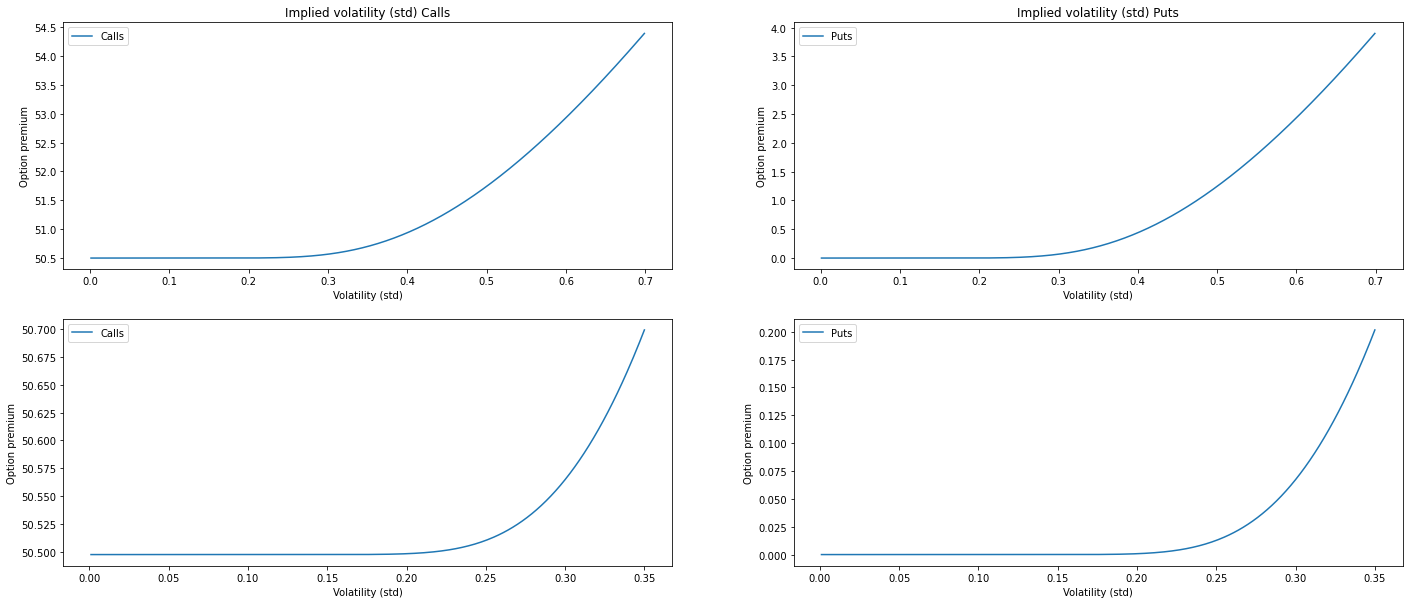

In [22]:
# We compare previous res with black-scholes implementation
thsl, casl, pusl = plot_vol_bs(s0, r, 50, T)

In [23]:
print(casl[289], casl[290])
print(thsl[289], thsl[290])

50.54858421986132 50.550068269404136
0.29 0.291


We can see that the implied vol found earlier for strike = 50 at 0.288 is coherent.

/var/folders/9s/mnbf7ynj4250m39tyvxgpknw0000gn/T/ipykernel_33813/2875168665.py:15: RuntimeWarning: divide by zero encountered in true_divide
  return (np.log(s/k) + (r + (sigma**2)/2)*t)/(sigma*np.sqrt(t))


Implied volatility (std) calculation done.


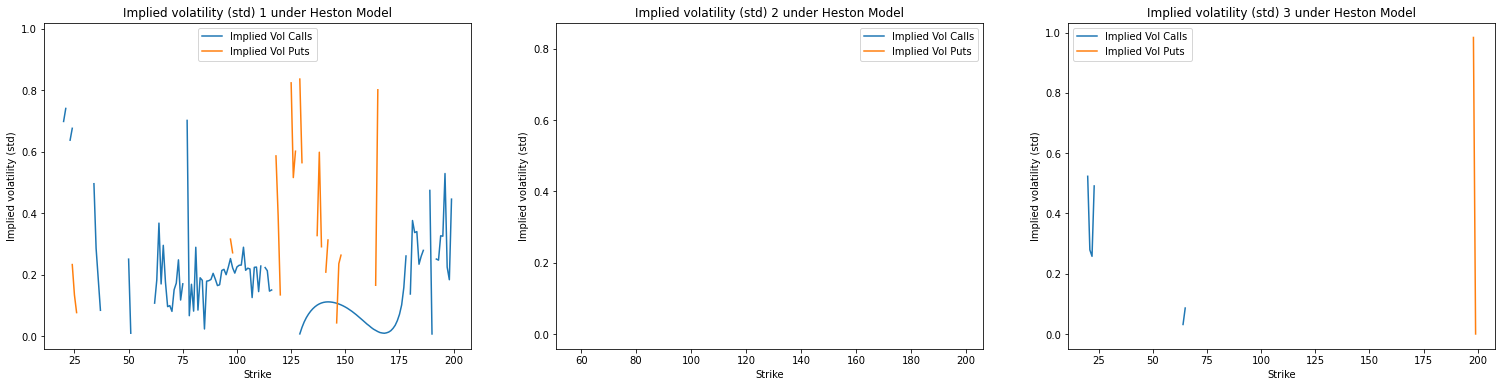

In [24]:
pivo, civo = plot_vol_smile(s0, ks_eur, calls_list_eur, puts_list_eur, r, T, implementation="own")

Doesn't work